# Recomender system

In [1]:
# Imports
import pandas as pd
import numpy as np
np.random.seed(42)
from scipy.sparse import csr_matrix
from lightfm import LightFM
from tqdm import tqdm
import joblib
from joblib import dump, load
from lightfm.data import Dataset
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('train.csv')
metadata = pd.read_csv('metadata.csv', sep=";")

In [2]:
# Dataset
data.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume
0,0,90627,STATIONARY,18332.0,2021-02-18 22:52:00.0,2021-02-18 23:35:00.0,0
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00.0,2021-03-25 00:01:00.0,0
2,1,3387,STB,895.0,2021-03-15 10:05:00.0,2021-03-15 10:23:00.0,0
3,1,3387,STB,895.0,2021-03-15 10:23:00.0,2021-03-15 11:18:00.0,1
4,1,3387,STB,26062.0,2021-03-16 09:24:00.0,2021-03-16 09:44:00.0,0


In [3]:
data.shape

(3657801, 7)

In [4]:
data.isna().sum() / data.shape[0]

customer_id    0.000000
account_id     0.000000
device_type    0.000008
asset_id       0.000006
tunein         0.000000
tuneout        0.000000
resume         0.000000
dtype: float64

    There is missing data in the variable asset_id, this data has no information because we do not know which content was the user watching to. Due to this fact we are going to drop the rows that have missing values. 

In [34]:
data = data[data['asset_id'].notna()]

In [184]:
# Metadata
metadata.head()

,asset_id,content_id,title,reduced_title,episode_title,show_type,released_year,country_of_origin,category,keywords,...,language_rating,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date
0,15188,0.0,Ep:17 Tiempos Compulsivos,Tiempos_Compul_E17,Episodio 17,Serie,2012.0,AR,Drama,"Trastornos,Médicos,Tragicómica,Telenovela,Enfe...",...,N,N,N,N,N,N,2017-12-01T10:18:15.0Z,2019-01-26T06:37:18.0Z,2017-12-01T00:00:00.0Z,2020-12-01T23:59:59.0Z
1,24940,1.0,7 Cajas,7_Cajas,NaN,Película,2012.0,PY,Suspenso/Acción,"Latinoamérica,Pobreza,Crimen,Pandillas",...,N,N,N,Y,N,N,2017-12-19T20:58:15.0Z,2019-09-17T19:02:03.0Z,2017-12-15T00:00:00.0Z,2022-12-14T23:59:59.0Z
2,21939,2.0,La Maldición de las Hormigas Gigantes,La_Maldicion_de_las,NaN,Película,2016.0,FI,Terror/Comedia,"Criaturas,Plagas,Adolescentes,Fantasía,Video J...",...,N,N,N,N,N,N,2018-02-16T13:51:07.0Z,2020-04-28T14:16:38.0Z,2018-01-25T00:00:00.0Z,2020-12-01T23:59:59.0Z
3,9005,3.0,Una Mujer Fantástica,Una_Mujer_Fantastic,NaN,Película,2017.0,CL,Drama,"LGBT,Mujeres,Latinoamérica",...,N,N,N,N,Y,N,2018-05-26T11:58:44.0Z,2019-11-15T03:00:23.0Z,2018-05-27T00:00:00.0Z,2021-04-30T23:59:59.0Z
4,7391,4.0,Star Trek,Star_Trek,NaN,Película,2009.0,US,Ciencia Ficción/Aventura,"Fantasía,Galaxia,Futurismo,Aliens,Criaturas",...,N,N,N,Y,N,N,2019-05-03T20:07:24.0Z,2020-04-09T04:37:29.0Z,2019-05-02T00:00:00.0Z,2020-12-31T23:59:59.0Z


In [6]:
metadata.isna().sum() / metadata.shape[0]

asset_id              0.000000
content_id            0.000634
title                 0.000000
reduced_title         0.000000
episode_title         0.125121
show_type             0.000121
released_year         0.000000
country_of_origin     0.000121
category              0.000000
keywords              0.000060
description           0.000060
reduced_desc          0.000000
cast_first_name       0.263456
credits_first_name    0.378771
run_time_min          0.000000
audience              0.000030
made_for_tv           0.000000
close_caption         0.000000
sex_rating            0.000000
violence_rating       0.000000
language_rating       0.000000
dialog_rating         0.000000
fv_rating             0.000000
pay_per_view          0.000000
pack_premium_1        0.000000
pack_premium_2        0.000000
create_date           0.000000
modify_date           0.000000
start_vod_date        0.000000
end_vod_date          0.000000
dtype: float64

    Drop the values in the metadata frame that contet_id has no values. 

In [35]:
metadata = metadata[metadata['content_id'].notna()]

# Create ratings 

    As there are no ratings in the dataset I derive them from the time the user spend watching the program and the kind of program it was watching, for kind of program I mean if is a movie or a series. 

In [36]:
# Transform to datetime
data["tuneout"]  = pd.to_datetime(data["tuneout"] )
data["tunein"]  = pd.to_datetime(data["tunein"] )

# Calculate delta time
data["time_dif"] = data["tuneout"] - data["tunein"]

# Deltatime to minutes
data["time_dif_sec"] = data["time_dif"].apply(lambda x: x.total_seconds())
data["time_dif_min"] = (data["time_dif_sec"]/60)

# Create the complete database merging both frames
complete = data.merge(metadata, how="left", left_on="asset_id", right_on="asset_id")

# Reduce the complete dataframe in order to work to create the ratings.
complete_red=complete[["account_id","content_id","time_dif_min","run_time_min"]]

# Where the time watched is bigger than total time, replace total time (because the session was still open after ending the movie)
complete_red["real_time"] = np.where(complete_red["time_dif_min"]>complete_red["run_time_min"],complete_red["run_time_min"], complete_red["time_dif_min"])

ratings=complete_red.groupby(["account_id", "content_id"]).agg(
    episodes = pd.NamedAgg(column="content_id", aggfunc="count"),
    total_time = pd.NamedAgg(column="run_time_min", aggfunc="sum"),
    view = pd.NamedAgg(column="real_time", aggfunc="sum")
)

# Calculate the rating of visualization
ratings["rating"] = ratings["view"]/ratings["total_time"]

C:\Users\marti\AppData\Local\Temp\ipykernel_11756\3418632120.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_red["real_time"] = np.where(complete_red["time_dif_min"]>complete_red["run_time_min"],complete_red["run_time_min"], complete_red["time_dif_min"])


### Weighting the amount of time each user watch: 
* If the total time is less than 60 minutes, then it is a series, if you saw only one chapter penalize. -0.3 to the rating. 
* If he saw more than two chapters, he caught it a lot, put the rating at 1.

In [37]:
ratings['rating_pond'] = np.where(
   (ratings['total_time']<=60) & (ratings['episodes'] == 1) , (ratings["rating"]-0.3), ratings["rating"]
   )

ratings['rating_pond'] = np.where(
    (ratings['episodes'] > 2) , 1, ratings["rating_pond"]
   )

In [38]:
# Create the complete database merging both frames
complete = complete.merge(ratings["rating_pond"], how="left", left_on=["content_id","account_id"], right_on=["content_id","account_id"])

Here we remove the movies that are going to be removed before the prediction date and those that are released after the recommendation date

In [39]:
complete['start_date'] = pd.to_datetime(complete['start_vod_date'])
# print(format(complete['start_date']))
complete['end_date'] = pd.to_datetime(complete['end_vod_date'])
# print(format(complete['end_date']))
complete = complete[(complete['start_date'] <= '2021-03-01 00:00:00+00:00') & (complete['end_date'] >= '2021-03-01 23:59:59+00:00') ]

# Exploratory Data Analysis

In [59]:
# Only run it for doing exploratory data analisys, drop it for modelling.
complete["ones"] = 1

### Device type

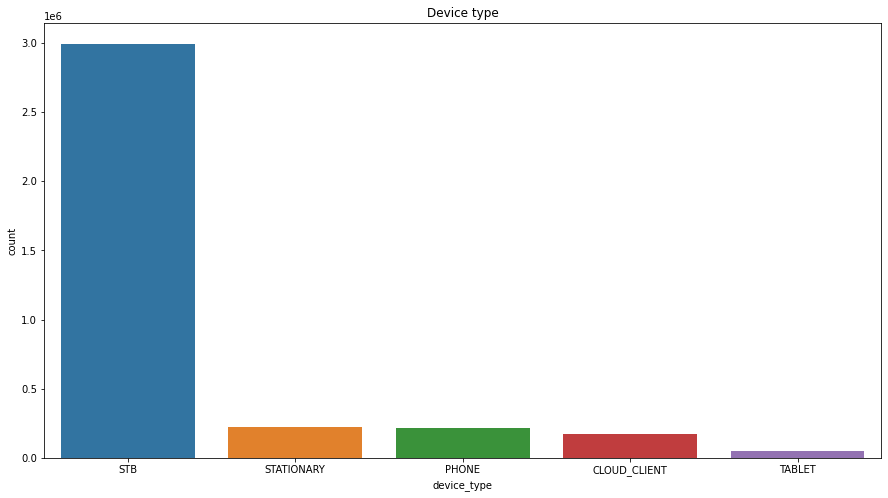

In [28]:
plt.figure(figsize=(15,8))
sns.countplot(x='device_type', data=complete,
             order = complete['device_type'].value_counts().index).set(title='Device type')
plt.show();

In [46]:
exp=complete[['device_type','rating_pond','ones']].drop_duplicates()
exp=exp.groupby('device_type', as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by='rating_pond',ascending=False)
exp.columns=["Device", "Rating","Count"]
display(exp.head())

,Device,Rating,Count
0,CLOUD_CLIENT,0.435604,8254
3,STB,0.434334,14836
2,STATIONARY,0.419919,7521
1,PHONE,0.378598,7150
4,TABLET,0.353276,3037


    We can appreciate the same amount of rating in the different devices.
    And that the majority of the people watch the content by STB that is the flow decoder.

### Country of origin

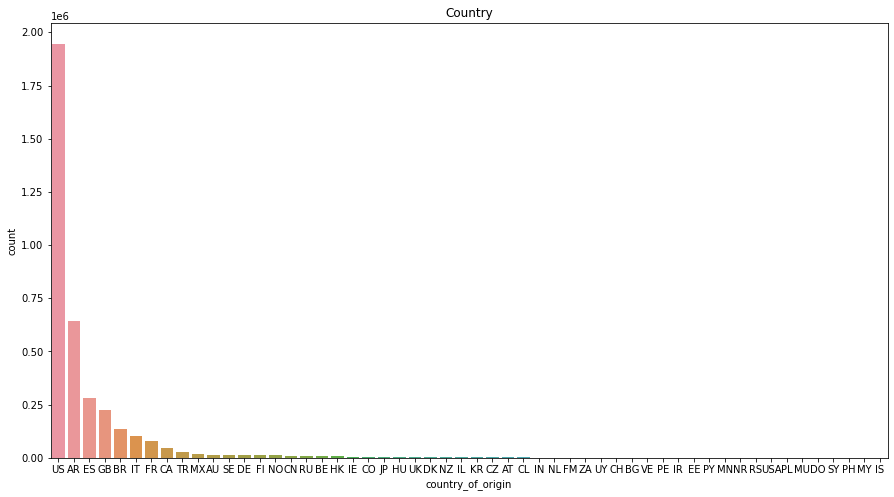

In [27]:
plt.figure(figsize=(15,8))
sns.countplot(x='country_of_origin', data=complete,
             order = complete['country_of_origin'].value_counts().index).set(title='Country')
plt.show();

In [47]:
variable = 'country_of_origin'
variable_name = "Country"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by='ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Country,Rating,Count
49,US,0.430173,13597
0,AR,0.423231,7926
20,GB,0.412772,7382
16,ES,0.400275,5134
28,IT,0.381055,2861


    Most watched movies are from United states and from Argentina, this is related to the fact that the database belongs to a company from this county. Is it remarkable that even though is it a database form Argentina, content from United States is the most watched. 
    The content with the bigger mean ratings have very few samples, only one good movie could have increased the rating through big values. 

### Category

In [48]:
variable = 'category'
variable_name = "Category"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Category,Rating,Count
92,Drama,0.411090,7482
111,Drama/Romance,0.392572,5429
112,Drama/Suspenso,0.402142,4674
100,Drama/Crimen,0.390347,4576
58,Comedia/Romance,0.417495,4464


    The most watched Category is the Drama, we can see in the table of the most watches categories this kind of movies in three different sub categories: Drama, Drama/Romance, Drama/Crimen and Drama/Suspenso. 
    After Drama the most watched categories are Comedia and Infantil/Animación.

### Cast first name

In [49]:
variable = 'cast_first_name'
variable_name = "Cast first name"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Cast first name,Rating,Count
3365,"Santiago del Moro, Donato de Santis, Damián Be...",0.398205,947
923,Diego Armando Maradona,0.290271,596
1087,"Emilia Clarke, Kit Harington, Peter Dinklage, ...",0.332348,448
2783,"Milo Ventimiglia, Mandy Moore, , Chrissy Metz",0.393784,407
816,"Daniel Radcliffe, Rupert Grint, Emma Watson, A...",0.445244,401


    Santiago del Moro, Donato de Santis, Damián Betular	most watched movies and very high rating.

### Credits first name

In [50]:
variable = 'credits_first_name'
variable_name = "Credits first name"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Credits first name,Rating,Count
2813,Steven Spielberg,0.377071,1272
622,Daniel Barone,0.339969,970
1683,Kenny Ortega,0.401842,889
741,David Yates,0.430886,888
2418,Quentin Tarantino,0.406373,885


        Steven Spielberg most watched movies and but not so high rating. 

### Audience

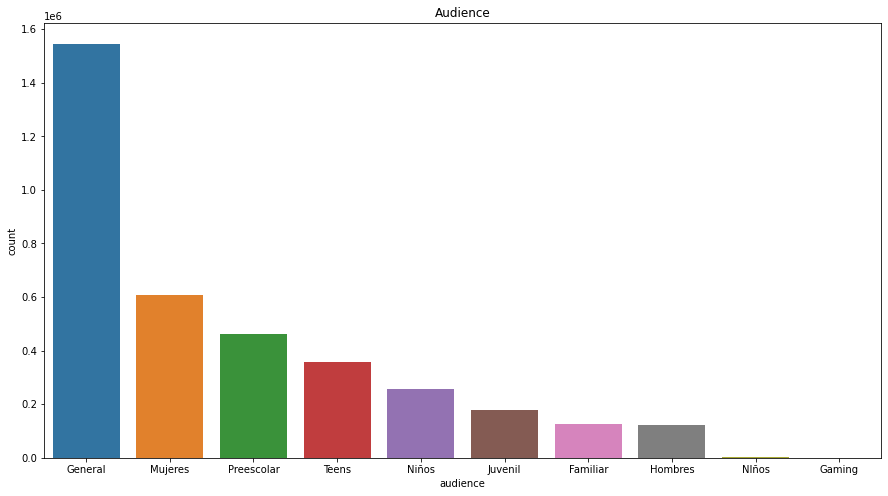

In [34]:
plt.figure(figsize=(15,8))
sns.countplot(x='audience', data=complete,
             order = complete['audience'].value_counts().index).set(title='Audience')
plt.show();

In [51]:
variable = 'audience'
variable_name = "Audience"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Audience,Rating,Count
2,General,0.431661,13721
3,Hombres,0.413284,7385
5,Mujeres,0.409274,6476
0,Familiar,0.441859,6220
4,Juvenil,0.393297,5877


    After general audience, content for women is the most popular among watched content. 

### Title

In [52]:
variable = 'title'
variable_name = "Title"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Title,Rating,Count
4283,La odisea de los giles,0.455915,292
2288,El lobo de Wall Street,0.447959,279
2444,Emma,0.456489,259
4993,Raúl. La democracia desde adentro,0.449041,246
4122,La Liga de la Justicia de Zack Snyder,0.370178,236


    Most watched title La odisea de los giles and El lobo de Wall Street, but great rating among most watched content.

### Show type

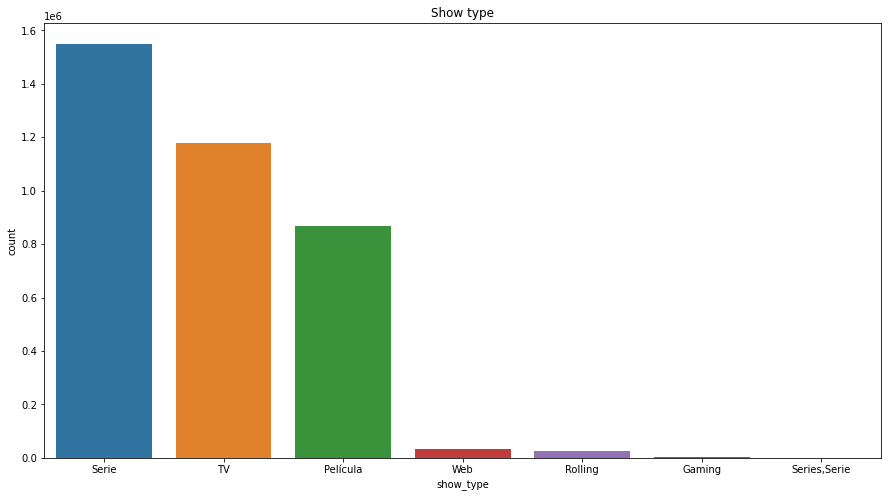

In [42]:
plt.figure(figsize=(15,8))
sns.countplot(x='show_type', data=complete,
             order = complete['show_type'].value_counts().index).set(title='Show type')
plt.show();

In [53]:
variable = 'show_type'
variable_name = "Show type"
exp=complete[[variable,'rating_pond','ones']].drop_duplicates()
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Show type,Rating,Count
1,Película,0.440471,14761
3,Serie,0.431946,6218
5,TV,0.379108,4517
2,Rolling,0.316619,781
6,Web,0.430440,264


## First model
    Train test split:

In [40]:
# Create train and test database as requested
train = complete.loc[(complete["tunein"] <= "2021-02-28 23:59:59")]
test = complete.loc[(complete["tunein"] > "2021-02-28 23:59:59")]

In [41]:
# Crate interactions matrix
interactions = train[["account_id", "content_id", "rating_pond"]].drop_duplicates(keep='first')

In [15]:
# Remove some data frames to prevent run off memory
# import gc
# import pandas as pd

# del [[complete,complete_red,ratings]]
# gc.collect()
# complete=pd.DataFrame()
# complete_red=pd.DataFrame()
# ratings=pd.DataFrame()

In [42]:
interactions_matrix = interactions.pivot(index="account_id", columns="content_id", values="rating_pond")

In [43]:
interactions_matrix = interactions_matrix.fillna(0)

In [44]:
interactions_matrix.shape

(97499, 3022)

In [19]:
# interactions_matrix.head()

In [45]:
# Create dictionaries for future references
user_id = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
    
item_id = list(interactions_matrix.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

In [46]:
interactions_matrix_csr = csr_matrix(interactions_matrix.values)
interactions_matrix_csr

<97499x3022 sparse matrix of type '<class 'numpy.float64'>'
	with 589639 stored elements in Compressed Sparse Row format>

In [24]:
# Create collaborative filtering predictive model 
colaborative_model = LightFM(random_state=0,
                loss='warp',
                learning_rate=0.01,
                no_components=100)

colaborative_model = colaborative_model.fit(interactions_matrix_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

In [23]:
# Save the model
joblib.dump(colaborative_model, "colaborative_model.joblib")

# Load model once
# model: LightFM = joblib.load("/model/files/model.joblib")    

['colaborative_model.joblib']

# Cold start

    For those users that are not part of the traininga frame, we need to recommend something. The first approach is to recommend the most popular items. 

In [47]:
popularity_df=complete_red[["account_id","content_id"]].drop_duplicates()
popularity_df=popularity_df.groupby('content_id', as_index=False).agg({"account_id": "count"}).sort_values(by='account_id',ascending=False)
popularity_df.columns=["content_id", "popularity"]
display(popularity_df.head())

,content_id,popularity
1764,2040.0,13629
3515,3806.0,9377
3609,3900.0,9082
3839,4133.0,8722
1707,1983.0,6695


In [48]:
popular_content = popularity_df.head(20).content_id

In [26]:
test.head()

,customer_id,account_id,device_type,asset_id,tunein,tuneout,resume,time_dif,time_dif_sec,time_dif_min,...,dialog_rating,fv_rating,pay_per_view,pack_premium_1,pack_premium_2,create_date,modify_date,start_vod_date,end_vod_date,rating_pond
1,0,90627,STATIONARY,24727.0,2021-03-24 23:17:00,2021-03-25 00:01:00,0,0 days 00:44:00,2640.0,44.0,...,N,N,N,Y,N,2021-03-17T20:31:21.0Z,2021-03-25T23:15:49.0Z,2021-03-18T00:00:00.0Z,2021-06-30T23:59:59.0Z,1.000000
2,1,3387,STB,895.0,2021-03-15 10:05:00,2021-03-15 10:23:00,0,0 days 00:18:00,1080.0,18.0,...,N,N,N,N,N,2021-03-05T18:37:58.0Z,2021-03-08T02:06:03.0Z,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,0.666667
3,1,3387,STB,895.0,2021-03-15 10:23:00,2021-03-15 11:18:00,1,0 days 00:55:00,3300.0,55.0,...,N,N,N,N,N,2021-03-05T18:37:58.0Z,2021-03-08T02:06:03.0Z,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,0.666667
4,1,3387,STB,26062.0,2021-03-16 09:24:00,2021-03-16 09:44:00,0,0 days 00:20:00,1200.0,20.0,...,N,N,N,N,N,2021-03-06T13:47:10.0Z,2021-03-08T02:06:06.0Z,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,0.234694
5,1,3387,STB,26062.0,2021-03-16 09:44:00,2021-03-16 09:47:00,0,0 days 00:03:00,180.0,3.0,...,N,N,N,N,N,2021-03-06T13:47:10.0Z,2021-03-08T02:06:06.0Z,2021-03-08T00:00:00.0Z,2021-03-28T23:59:00.0Z,0.234694


# Predictions of the first model

    To assess the capacity of our model we are going to calculate the predictions for the test set. 

In [27]:
#define where we are going to store the recommendations
recomms_dict = {
    'account_id': [],
    'recomms': []
}

#we obtain number of users and number of items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

#for each user of the test dataset, we generate recommendations
for user in tqdm(test.account_id.unique()):

    #-----------
    # Validate if the user is in the interactions matrix (interactions_matrix.index)
    if user in interactions_matrix.index:
    #-----------

        # If the user is in train, it is not cold start. We use the model to recommend
        user_x = user_dict[user] #we look for the user's index in the array (we transform id to index)

        #---------------
        # Generate predictions for the user x
        preds = colaborative_model.predict(user_ids=user_x, item_ids = item_ids)
        #--------------

        #--------------
        # order the predictions from lowest to highest and stay with 30.
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        recomms = list(pd.Series(scores.sort_values(ascending=False).index))[:30] #Retain the first 30
        #--------------

        #--------------
        # Get list of contents previously viewed by the user (in the train set)
        watched_contents = train[(train.account_id==user_x)].content_id.unique()
        #---------------------

        #---------------------
        # Filter contents already viewed
        recomms = [rec for rec in recomms if rec not in watched_contents]
        #--------------------

        # We keep the recommendations in the dictionary
        recomms_dict['account_id'].append(user)
        recomms_dict['recomms'].append(recomms)

        # In this else statement we are going to treat the users that are not in train data (cold start)
    else:
        recomms_dict['account_id'].append(user)
        # Recomend most popular content
        recomms_dict['recomms'].append(popular_content)


100%|███████████████████████████████████████████████████████████████████████████| 87632/87632 [08:16<00:00, 176.49it/s]


In [28]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df
recomms_df.to_csv("Recomendaciones_1Modelo.csv")

# Metrics
    
    Once we have calculated the predictions we are going to calculate the metric, in this case the performance is going to be evaluated calculating: 
    MAP = mean average precision.

In [29]:
# Test set ratings
ideal_recoms = test\
    .sort_values(by=["account_id","rating_pond"], ascending=False)\
    .groupby("account_id", as_index=False)\
    .agg({"content_id": "unique"})
ideal_recoms.head()

,account_id,content_id
0,2,[433.0]
1,3,"[1949.0, 4010.0, 3169.0, 3487.0, 461.0, 4059.0..."
2,4,"[513.0, 565.0, 2212.0, 4129.0, 4340.0, 2341.0,..."
3,5,[2259.0]
4,6,"[2900.0, 4065.0, 3211.0, 3386.0, 3388.0, 3902.0]"


In [30]:
# My recomendations
recomms_df.head()

,account_id,recomms
0,90627,"[3806.0, 3900.0, 116.0, 1462.0, 724.0, 1020.0,..."
1,3387,1764 2040.0 3515 3806.0 3609 3900.0 3...
2,3388,"[2040.0, 116.0, 724.0, 1539.0, 3716.0, 729.0, ..."
3,3389,"[1877.0, 1018.0, 1020.0, 3900.0, 2040.0, 3806...."
4,3393,"[2160.0, 3572.0, 20.0, 2941.0, 1483.0, 36.0, 3..."


In [31]:
df_map = ideal_recoms.merge(recomms_df, how="left", left_on="account_id", right_on="account_id")[["account_id", "content_id", "recomms"]]
df_map.columns = ["account_id", "ideal", "recomms"]
df_map.head()

,account_id,ideal,recomms
0,2,[433.0],"[3026.0, 2591.0, 3364.0, 2040.0, 1573.0, 1971...."
1,3,"[1949.0, 4010.0, 3169.0, 3487.0, 461.0, 4059.0...","[3711.0, 3210.0, 2815.0, 2972.0, 1008.0, 475.0..."
2,4,"[513.0, 565.0, 2212.0, 4129.0, 4340.0, 2341.0,...","[3806.0, 3210.0, 2827.0, 173.0, 4366.0, 2815.0..."
3,5,[2259.0],"[3806.0, 3900.0, 3690.0, 3598.0, 2160.0, 2040...."
4,6,"[2900.0, 4065.0, 3211.0, 3386.0, 3388.0, 3902.0]","[3716.0, 2040.0, 116.0, 1140.0, 3900.0, 3681.0..."


In [32]:
aps = [] # empty list to store the AP of each recommendation

for pred, label in df_map[["ideal", "recomms"]].values:
    n = len(pred) # quantity of recomended elements
    arange = np.arange(n, dtype=np.int32) + 1. 
    rel_k = np.in1d(pred[:n], label) # list of booleans indicating the relevance of each item
    tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # list with the counter of true positives
    denom = arange[rel_k] # positions where the relevant items are located
    ap = (tp / denom).sum() / len(label) # average precision
    aps.append(ap)

In [33]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.02316


    The first approach is not bad as we perform better than the proposed baseline, the competition suggested to perform better than a MAP of 0.014, that is the value of the metric obteined if we simply recommend the twenty most popular content during the train quarter (in terms of the number of different profiles that viewed it at least once), filtering previously viewed content.

# Hyperparameter search
## Subsample dataframe to acelerate process of investigation
     To perform the final model I will implement all the data.

In [56]:
complete = complete.loc[np.random.choice(complete.index, 30000, replace=False)]
complete.to_csv("subsample_30000.csv")

In [2]:
complete2 = pd.read_csv('subsample_30000.csv')

complete2["tuneout"]  = pd.to_datetime(complete2["tuneout"] )
complete2["tunein"]  = pd.to_datetime(complete2["tunein"] )

# Create train and test database as requested
train = complete2.loc[(complete2["tunein"] <= "2021-02-28 23:59:59")]
test = complete2.loc[(complete2["tunein"] > "2021-02-28 23:59:59")]

# Crate interactions matrix
interactions = train[["account_id", "content_id", "rating_pond"]].drop_duplicates(keep='first')
interactions_matrix = interactions.pivot(index="account_id", columns="content_id", values="rating_pond")
interactions_matrix = interactions_matrix.fillna(0)
interactions_matrix_csr = csr_matrix(interactions_matrix.values)

# Create dictionaries for future references
user_id = list(interactions_matrix.index)
user_dict = {}
counter = 0 
for i in user_id:
    user_dict[i] = counter
    counter += 1
    
item_id = list(interactions_matrix.columns)
item_dict = {}
counter = 0 
for i in item_id:
    item_dict[i] = counter
    counter += 1

In [86]:
def search(learning_rate, n_components, interactions_matrix_csr,interactions_matrix,train,test,popular_content):
    # Create dataframe for results:
    results = pd.DataFrame(columns = ['Learning Rate', 'N components',"MAP"])
    for i in learning_rate:
        for j in n_components:
            # Create collaborative filtering predictive model 
            model = LightFM(random_state=0,
                            loss='warp',
                            learning_rate=i,
                            no_components=j)

            model = model.fit(interactions_matrix_csr,
                              epochs=50,
                              num_threads=16, verbose=False)
            
            # Obtain predictions
            #define where we are going to store the recommendations
            recomms_dict = {
                'account_id': [],
                'recomms': []
            }

            #we obtain number of users and number of items
            n_users, n_items = interactions_matrix.shape
            item_ids = np.arange(n_items)

            #for each user of the test dataset, we generate recommendations
            for user in tqdm(test.account_id.unique()):

                #-----------
                # Validate if the user is in the interactions matrix (interactions_matrix.index)
                if user in interactions_matrix.index:
                #-----------

                    # If the user is in train, it is not cold start. We use the model to recommend
                    user_x = user_dict[user] #we look for the user's index in the array (we transform id to index)

                    #---------------
                    # Generate predictions for the user x
                    preds = model.predict(user_ids=user_x, item_ids = item_ids)
                    #--------------

                    #--------------
                    # order the predictions from lowest to highest and stay with 30.
                    scores = pd.Series(preds)
                    scores.index = interactions_matrix.columns
                    recomms = list(pd.Series(scores.sort_values(ascending=False).index))[:30] #Retain the first 30
                    #--------------

                    #--------------
                    # Get list of contents previously viewed by the user (in the train set)
                    watched_contents = train[(train.account_id==user_x)].content_id.unique()
                    #---------------------

                    #---------------------
                    # Filter contents already viewed
                    recomms = [rec for rec in recomms if rec not in watched_contents]
                    #--------------------

                    # We keep the recommendations in the dictionary
                    recomms_dict['account_id'].append(user)
                    recomms_dict['recomms'].append(recomms)

                    # In this else statement we are going to treat the users that are not in train data (cold start)
                else:
                    recomms_dict['account_id'].append(user)
                    # Recomend most popular content
                    recomms_dict['recomms'].append(popular_content)
            
            # Recomendations to data frame
            recomms_df = pd.DataFrame(recomms_dict)
            
            # Obtain Metrics
            # Test set ratings
            ideal_recoms = test\
                .sort_values(by=["account_id","rating_pond"], ascending=False)\
                .groupby("account_id", as_index=False)\
                .agg({"content_id": "unique"})
            
            df_map = ideal_recoms.merge(recomms_df, how="left", left_on="account_id", right_on="account_id")[["account_id", "content_id", "recomms"]]
            df_map.columns = ["account_id", "ideal", "recomms"]
            
            # Calculate MAP
            aps = [] # empty list to store the AP of each recommendation

            for pred, label in df_map[["ideal", "recomms"]].values:
                n = len(pred) # quantity of recomended elements
                arange = np.arange(n, dtype=np.int32) + 1. 
                rel_k = np.in1d(pred[:n], label) # list of booleans indicating the relevance of each item
                tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # list with the counter of true positives
                denom = arange[rel_k] # positions where the relevant items are located
                ap = (tp / denom).sum() / len(label) # average precision
                aps.append(ap)
                
            MAP = np.mean(aps)
            result_partial = {"Learning Rate":i,
                                "N components":j,
                                "MAP":MAP
                                }
            results = results.append(result_partial, 
                                            ignore_index = True)
    return results

In [87]:
learning_rate = [0.5,0.1,0.01,0.001]
n_components = [10,50,100,150,200,300,500]

# Parameters of the function:
# Learning rates, number of components, database
results = search(learning_rate, n_components, interactions_matrix_csr,interactions_matrix,train,test,popular_content)

100%|████████████████████████████████████████████████████████████████████████████| 7988/7988 [00:02<00:00, 3426.44it/s]
C:\Users\marti\AppData\Local\Temp\ipykernel_2268\426492521.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_partial,
100%|████████████████████████████████████████████████████████████████████████████| 7988/7988 [00:02<00:00, 3094.81it/s]
C:\Users\marti\AppData\Local\Temp\ipykernel_2268\426492521.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_partial,
100%|████████████████████████████████████████████████████████████████████████████| 7988/7988 [00:02<00:00, 2692.41it/s]
C:\Users\marti\AppData\Local\Temp\ipykernel_2268\426492521.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

100%|████████████████████████████████████████████████████████████████████████████| 7988/7988 [00:03<00:00, 2623.72it/s]
C:\Users\marti\AppData\Local\Temp\ipykernel_2268\426492521.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_partial,
100%|████████████████████████████████████████████████████████████████████████████| 7988/7988 [00:03<00:00, 2361.59it/s]
C:\Users\marti\AppData\Local\Temp\ipykernel_2268\426492521.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(result_partial,
100%|████████████████████████████████████████████████████████████████████████████| 7988/7988 [00:03<00:00, 2138.37it/s]
C:\Users\marti\AppData\Local\Temp\ipykernel_2268\426492521.py:100: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

In [92]:
results.sort_values('MAP', ascending=False).head(10)

,Learning Rate,N components,MAP
17,0.01,150.0,0.0106
19,0.01,300.0,0.010529
18,0.01,200.0,0.010499
20,0.01,500.0,0.010481
16,0.01,100.0,0.010453
15,0.01,50.0,0.010336
10,0.1,150.0,0.009875
14,0.01,10.0,0.009853
9,0.1,100.0,0.009778
8,0.1,50.0,0.009776


    The best metrics are obtained with the hyperparameters: 
* learning rate = 0.01	
* number of components = 150.0
    
    All the following results in descending order involves the same value of learning rate, in case of popularity bias we will need to train the model with a bigger learning rate. The best model with a bigger learning rate is achived in:
* learning rate = 0.1	
* number of components = 150.0

# Replacing cold start
    
    Now I am going to implement a simple classification model for those users that do not belong to the data base. 
    First of all I need to filter from the training data those users that have been recommended the most popular movies. 
    I want to know if with a simple classification model I can perform better than in the previous algorithm, but I have one problem, I am only recommending only 1 movie each time we enter with a prediction request. I should investigate how to predict multiple outputs, for future aplications. 

    Filter variables of interest

In [64]:
train_filt=train.dropna(axis=0)

In [65]:
train_filt=train_filt[["content_id",'device_type','resume', "show_type",'released_year', 'country_of_origin', 'category', 'audience', 'made_for_tv', 'close_caption','sex_rating', 'violence_rating', 'language_rating', 'dialog_rating','fv_rating', 'pay_per_view', 'pack_premium_1', 'pack_premium_2']]

In [66]:
y=train_filt["content_id"]

In [67]:
X=train_filt[vars]

    Encode data to do the classification.

In [68]:
labelTransformer = DictVectorizer()
data_dict = X.to_dict('records')
X_encoded = labelTransformer.fit_transform(data_dict)

In [69]:
# labelTransformer.transform(X.iloc[1].to_dict())

    Encode the response variable.

In [70]:
# Fitting Random Forest Classification to the Training set
# classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
# classifier.fit(X_encoded, y)
# dump(classifier, 'RandomForestClassification_All.pkl') 
# Load it
classifier = load('RandomForestClassification_All.pkl')

    Assess predictions for the last model

In [107]:
import random

recomms_dict = {
    'account_id': [],
    'recomms': []
}

n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

for user in tqdm(test.account_id.unique()):

    #-----------
    if user in interactions_matrix.index:
    #-----------

        user_x = user_dict[user] 

        #---------------
        preds = colaborative_model.predict(user_ids=user_x, item_ids = item_ids)
        #--------------

        #--------------
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        recomms = list(pd.Series(scores.sort_values(ascending=False).index))[:30] 
        #--------------

        #--------------
        watched_contents = train[(train.account_id==user_x)].content_id.unique()
        #---------------------

        #---------------------
        recomms = [rec for rec in recomms if rec not in watched_contents]
        #--------------------

        recomms_dict['account_id'].append(user)
        recomms_dict['recomms'].append(recomms)

    else:
        new_user = test[test["account_id"]==user]
        # Select variables of interest.
        new_user = new_user[['device_type','resume', "show_type",'released_year', 'country_of_origin', 'category', 'audience', 'made_for_tv', 'close_caption','sex_rating', 'violence_rating', 'language_rating', 'dialog_rating','fv_rating', 'pay_per_view', 'pack_premium_1', 'pack_premium_2']]
        
        # If there is no missing data predict with conten based RandomForest Classifier model
        # If is missing data predict a random most popular movie.
        pred_new_user = []
        for row in range(0,new_user.shape[0]):
            if new_user.iloc[row].isna().sum().sum() == 0:
                new_data = labelTransformer.transform(new_user.iloc[row].to_dict())
                pred = classifier.predict(new_data)
                pred_new_user.append(pred[0])
                
            else:
                pred_new_user.append(popular_content.iloc[random.randint(0, popular_content.shape[0]-1)])
        
        if len(pred_new_user) == 1:
            pred_new_user.append(popular_content.iloc[random.randint(0, popular_content.shape[0]-1)])
            pred_new_user.append(popular_content.iloc[random.randint(0, popular_content.shape[0]-1)])
            pred_new_user.append(popular_content.iloc[random.randint(0, popular_content.shape[0]-1)])
            pred_new_user.append(popular_content.iloc[random.randint(0, popular_content.shape[0]-1)])
        
        recomms = [seq[0] for seq in Counter(flat_list).most_common()]
        recomms_dict['account_id'].append(user)
        recomms_dict['recomms'].append(recomms)

100%|████████████████████████████████████████████████████████████████████████████| 87632/87632 [27:23<00:00, 53.33it/s]


In [108]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df
# recomms_df.to_csv("Recomendaciones_4toModelo.csv")

In [109]:
# Test set ratings
ideal_recoms = test\
    .sort_values(by=["account_id","rating_pond"], ascending=False)\
    .groupby("account_id", as_index=False)\
    .agg({"content_id": "unique"})
ideal_recoms.head()

,account_id,content_id
0,2,[433.0]
1,3,"[1949.0, 4010.0, 3169.0, 3487.0, 461.0, 4059.0..."
2,4,"[513.0, 565.0, 2212.0, 4129.0, 4340.0, 2341.0,..."
3,5,[2259.0]
4,6,"[2900.0, 4065.0, 3211.0, 3386.0, 3388.0, 3902.0]"


In [110]:
df_map = ideal_recoms.merge(recomms_df, how="left", left_on="account_id", right_on="account_id")[["account_id", "content_id", "recomms"]]
df_map.columns = ["account_id", "ideal", "recomms"]
df_map.head()

,account_id,ideal,recomms
0,2,[433.0],"[3026.0, 2591.0, 3364.0, 2040.0, 1573.0, 1971...."
1,3,"[1949.0, 4010.0, 3169.0, 3487.0, 461.0, 4059.0...","[3711.0, 3210.0, 2815.0, 2972.0, 1008.0, 475.0..."
2,4,"[513.0, 565.0, 2212.0, 4129.0, 4340.0, 2341.0,...","[3806.0, 3210.0, 2827.0, 173.0, 4366.0, 2815.0..."
3,5,[2259.0],"[3806.0, 3900.0, 3690.0, 3598.0, 2160.0, 2040...."
4,6,"[2900.0, 4065.0, 3211.0, 3386.0, 3388.0, 3902.0]","[3716.0, 2040.0, 116.0, 1140.0, 3900.0, 3681.0..."


In [111]:
aps = []

for pred, label in df_map[["ideal", "recomms"]].values:
    n = len(pred) 
    arange = np.arange(n, dtype=np.int32) + 1. 
    rel_k = np.in1d(pred[:n], label) 
    tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() 
    denom = arange[rel_k]
    ap = (tp / denom).sum() / len(label) 
    aps.append(ap)

In [112]:
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.02058


    The developed model is not better than the one with the cold start, so we are going to fit the final model by joining the results of the hyperparameter search and the model concidering the cold start and interpret its results.

# Final model
    
* Collaborative filtering + Cold start (Most Popular) + Hyperparameter search.

In [51]:
# Create collaborative filtering predictive model 
final_model = LightFM(random_state=0,
                loss='warp',
                learning_rate=0.01,
                no_components=150)

final_model = final_model.fit(interactions_matrix_csr,
                  epochs=100,
                  num_threads=16, verbose=False)

# Save the model
joblib.dump(final_model, "final_model.joblib")

# Load model once
# model: LightFM = joblib.load("/model/files/model.joblib")    

['final_model.joblib']

## Predictions

In [53]:
#define where we are going to store the recommendations
recomms_dict = {
    'account_id': [],
    'recomms': []
}

#we obtain number of users and number of items
n_users, n_items = interactions_matrix.shape
item_ids = np.arange(n_items)

#for each user of the test dataset, we generate recommendations
for user in tqdm(test.account_id.unique()):

    #-----------
    # Validate if the user is in the interactions matrix (interactions_matrix.index)
    if user in interactions_matrix.index:
    #-----------

        # If the user is in train, it is not cold start. We use the model to recommend
        user_x = user_dict[user] #we look for the user's index in the array (we transform id to index)

        #---------------
        # Generate predictions for the user x
        preds = final_model.predict(user_ids=user_x, item_ids = item_ids)
        #--------------

        #--------------
        # order the predictions from lowest to highest and stay with 30.
        scores = pd.Series(preds)
        scores.index = interactions_matrix.columns
        recomms = list(pd.Series(scores.sort_values(ascending=False).index))[:30] #Retain the first 30
        #--------------

        #--------------
        # Get list of contents previously viewed by the user (in the train set)
        watched_contents = train[(train.account_id==user_x)].content_id.unique()
        #---------------------

        #---------------------
        # Filter contents already viewed
        recomms = [rec for rec in recomms if rec not in watched_contents]
        #--------------------

        # We keep the recommendations in the dictionary
        recomms_dict['account_id'].append(user)
        recomms_dict['recomms'].append(recomms)

        # In this else statement we are going to treat the users that are not in train data (cold start)
    else:
        recomms_dict['account_id'].append(user)
        # Recomend most popular content
        recomms_dict['recomms'].append(popular_content)


100%|███████████████████████████████████████████████████████████████████████████| 78437/78437 [06:45<00:00, 193.46it/s]


In [54]:
recomms_df = pd.DataFrame(recomms_dict)
recomms_df
recomms_df.to_csv("RecomendationsFinalModel.csv")

## Metrics

In [55]:
# Test set ratings
ideal_recoms = test\
    .sort_values(by=["account_id","rating_pond"], ascending=False)\
    .groupby("account_id", as_index=False)\
    .agg({"content_id": "unique"})

df_map = ideal_recoms.merge(recomms_df, how="left", left_on="account_id", right_on="account_id")[["account_id", "content_id", "recomms"]]
df_map.columns = ["account_id", "ideal", "recomms"]

aps = [] # empty list to store the AP of each recommendation

for pred, label in df_map[["ideal", "recomms"]].values:
    n = len(pred) # quantity of recomended elements
    arange = np.arange(n, dtype=np.int32) + 1. 
    rel_k = np.in1d(pred[:n], label) # list of booleans indicating the relevance of each item
    tp = np.ones(rel_k.sum(), dtype=np.int32).cumsum() # list with the counter of true positives
    denom = arange[rel_k] # positions where the relevant items are located
    ap = (tp / denom).sum() / len(label) # average precision
    aps.append(ap)
    
MAP = np.mean(aps)
print(f'mean average precision = {round(MAP, 5)}')

mean average precision = 0.0251


    We can appreciate that the final model get better MAP results. 

# Interpretation of results:

In [56]:
res = pd.read_csv('RecomendationsFinalModel.csv')

In [57]:
res.columns
res=res.drop(['Unnamed: 0'],axis=1)

In [60]:
exp=complete[['account_id','ones']]
exp=exp.groupby('account_id', as_index=False).agg({'ones':"count"}).sort_values(by='ones',ascending=False)
exp.columns=["Account","Count"]
display(exp.head())

,Account,Count
6862,7107,3100
96046,99113,1650
99186,102343,1631
2935,3042,1463
81905,84543,1389


### Account_id == 7107

In [61]:
df_filt = complete[complete["account_id"]==7107]

    Select account_id = 7107 the user that most products have watched.

In [62]:
variable = 'category'
variable_name = "Category"
exp=df_filt[[variable,'rating_pond','ones']]
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Category,Rating,Count
4,Infantil/Dibujos Animados,0.999274,3055
2,Infantil,1.000000,40
1,Entretenimiento/Música,0.304426,3
0,Comedia,0.681818,1
3,Infantil/Animación,1.000000,1


    The selected user likes to  content for children.

In [63]:
res[res["account_id"]==7107].recomms.values

array(['[2160.0, 1139.0, 1316.0, 712.0, 20.0, 704.0, 684.0, 8.0, 45.0, 680.0, 304.0, 18.0, 2163.0, 106.0, 607.0, 55.0, 924.0, 2307.0, 2172.0, 558.0, 637.0, 641.0, 112.0, 2133.0, 914.0, 194.0, 496.0, 654.0, 491.0, 1803.0]'],
      dtype=object)

In [69]:
popularity_df.head(10)

,content_id,popularity
1764,2040.0,13629
3515,3806.0,9377
3609,3900.0,9082
3839,4133.0,8722
1707,1983.0,6695
603,729.0,5161
2658,2942.0,4863
2925,3210.0,4564
3096,3381.0,4527
1882,2160.0,4506


    By comparing the popular content with the recomendations for the user 7107, we can see that we are not in trouble of a popularity bias problem. 

In [70]:
recomendations = [2160.0, 1139.0, 1316.0, 712.0, 20.0, 704.0, 684.0, 8.0, 45.0, 680.0, 304.0, 18.0, 2163.0, 106.0, 607.0, 55.0, 924.0, 2307.0, 2172.0, 558.0, 637.0, 641.0, 112.0, 2133.0, 914.0, 194.0, 496.0, 654.0, 491.0, 1803.0]

In [71]:
movies=[]
for i,x in enumerate(recomendations):
    movies.append(metadata[metadata["content_id"]==x].title.iloc[0])

In [72]:
movies

['T:1 Ep:01 Paw Patrol, Patrulla Canina',
 'T:1 Ep:36 Bluey',
 'T:8 Ep:40 Peppa Pig',
 'T:1 Ep:43 T.O.T.S. Tiny Ones Transfer Service',
 'T:2 Ep:73 Puppy Dog Pals',
 'T:1 Ep:30 Mira: La detective del reino',
 'T:2 Ep:50 Muppet Babies',
 'T:1 Ep:05 Mickey: Aventuras sobre ruedas',
 'T:3 Ep:74 Doctora Juguetes',
 'T:2 Ep:65 Vampirina',
 'T:1 Ep:01 La Granja de Zenón',
 'T:1 Ep:21 PJ Masks: Héroes en pijamas',
 'T:1 Ep:01 Gallina Pintadita Mini',
 'T:1 Ep:08 Rocketeer',
 'La Granja de Zenón 4 Mix',
 'T:4 Ep:120 La casa de Mickey Mouse',
 'T:2 Ep:20 Mini Beat Power Rockers',
 'T:1 Ep:02 Los Polos',
 'T:1 Ep:01 Gallina Pintadita Collections',
 'T:5 Ep:110 Junior Express',
 'T:1 Ep:19 Fancy Nancy Clancy',
 'T:2 Ep:39 Nivis: Amigos de otro mundo',
 'T:3 Ep:76 Elena de Avalor',
 'T:1 Ep:01 Ranger Rob',
 'T:2 Ep:08 Mickey Mouse',
 'T:2 Ep:50 La Guardia del León',
 'T:4 Ep:01 Canciones del Zoo',
 'T:1 Ep:13 Calle Dálmatas 101',
 'T:1 Ep:01 La Granja de Zenón: La Serie',
 'T:2 Ep:01 44 Gatos']

    We can see that the recommended stuff are movies and series for children. 

### Account_id == 99113

In [73]:
df_filt = complete[complete["account_id"]==99113]

In [74]:
variable = 'category'
variable_name = "Category"
exp=df_filt[[variable,'rating_pond','ones']]
exp=exp.groupby(variable, as_index=False).agg({'rating_pond': "mean", 'ones':"count"}).sort_values(by= 'ones',ascending=False)
exp.columns=[variable_name, "Rating","Count"]
display(exp.head(5))

,Category,Rating,Count
19,Infantil/Dibujos Animados,0.996345,899
18,Infantil/Comedia,1.000000,389
16,Infantil,0.989309,122
1,Acción/Aventura,0.974261,115
17,Infantil/Animación,0.891025,58


    The selected user likes to  content for children.

In [75]:
res[res["account_id"]==99113].recomms.values

array(['[1139.0, 680.0, 3572.0, 558.0, 1483.0, 36.0, 20.0, 1508.0, 38.0, 3389.0, 3361.0, 71.0, 2160.0, 304.0, 1503.0, 3516.0, 3497.0, 1830.0, 894.0, 37.0, 704.0, 712.0, 1500.0, 18.0, 3292.0, 3847.0, 194.0, 1505.0, 1152.0]'],
      dtype=object)

In [76]:
popularity_df.head(10)

,content_id,popularity
1764,2040.0,13629
3515,3806.0,9377
3609,3900.0,9082
3839,4133.0,8722
1707,1983.0,6695
603,729.0,5161
2658,2942.0,4863
2925,3210.0,4564
3096,3381.0,4527
1882,2160.0,4506


In [77]:
recomendations =[1139.0, 680.0, 3572.0, 558.0, 1483.0, 36.0, 20.0, 1508.0, 38.0, 3389.0, 3361.0, 71.0, 2160.0, 304.0, 1503.0, 3516.0, 3497.0, 1830.0, 894.0, 37.0, 704.0, 712.0, 1500.0, 18.0, 3292.0, 3847.0, 194.0, 1505.0, 1152.0]

    By comparing the popular content with the recomendations for the user 7107, we can see that we are not in trouble of a popularity bias problem.     

In [78]:
movies=[]
for i,x in enumerate(recomendations):
    movies.append(metadata[metadata["content_id"]==x].title.iloc[0])

In [79]:
movies

['T:1 Ep:36 Bluey',
 'T:2 Ep:65 Vampirina',
 'El árbol de los deseos',
 'T:5 Ep:110 Junior Express',
 'Cigüeñas: La historia que no te contaron',
 'Madagascar 3: Los fugitivos',
 'T:2 Ep:73 Puppy Dog Pals',
 'Lluvia de hamburguesas 2',
 'Madagascar 2: Escape a África',
 'Animales al ataque',
 'Tarzán: La evolución de la leyenda',
 'Lluvia de hamburguesas',
 'T:1 Ep:01 Paw Patrol, Patrulla Canina',
 'T:1 Ep:01 La Granja de Zenón',
 '¿Y dónde están las rubias...?',
 'Wombat al combate',
 'Un Monstruo en Paris',
 '16 Deseos',
 'T:4 Ep:239 El Show Tom & Jerry',
 'Madagascar',
 'T:1 Ep:30 Mira: La detective del reino',
 'T:1 Ep:43 T.O.T.S. Tiny Ones Transfer Service',
 'Pixels',
 'T:1 Ep:21 PJ Masks: Héroes en pijamas',
 'Escandalosos: La película',
 'Descendientes',
 'T:2 Ep:50 La Guardia del León',
 'Godzilla',
 'Las aventuras de Sharkboy y Lavagirl']

    We can see that the recommended stuff are movies and series for children. 
    
    In conclusion the results of the predictions of the model are very accurate. In case we have had a popularity bias problem the solution could have been to increment the learning rate, so as to perform a more superficial learning, this would have improve the recomendations and drop the popular content from the predictions. 